# **Notebook 2 : Entraînement du Modèle CNN**

Dans ce notebook, nous entraînons un modèle de réseau neuronal convolutionnel (**CNN**) pour la classification des images. Les étapes clés sont :

- **Chargement des Images Prétraitées :** Nous utilisons les données d'images préparées dans le Notebook 1.
- **Utilisation de MobileNetV2 :** Nous importons le modèle **MobileNetV2** pré-entraîné sur ImageNet, sans la couche de classification finale.
- **Ajout de Couches Personnalisées :** Nous ajoutons des couches fully connected pour adapter le modèle à notre jeu de données spécifique.
- **Fine-tuning du Modèle :** Nous entraînons le modèle en deux phases :
  - **Phase 1 :** Nous gelons les couches du modèle pré-entraîné et entraînons uniquement les couches ajoutées.
  - **Phase 2 :** Nous dégelons certaines couches du modèle pré-entraîné pour affiner les poids et améliorer les performances.
- **Utilisation de `tf.data.Dataset` :** Nous utilisons des générateurs de données pour charger les images par lots et éviter les problèmes de mémoire.
- **Entraînement du Modèle :** Nous entraînons le modèle sur les données d'entraînement et évaluons sa performance sur les données de test.
- **Sauvegarde du Modèle :** Nous sauvegardons le modèle entraîné pour une utilisation ultérieure.

**Pourquoi ?**

L'utilisation d'un modèle pré-entraîné comme MobileNetV2 nous permet de bénéficier des connaissances acquises sur un grand jeu de données (ImageNet). Le fine-tuning nous permet d'adapter ces connaissances à notre jeu de données spécifique, améliorant ainsi la précision de la classification.


In [1]:
# Import des bibliothèques nécessaires
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [2]:
# Charger les fichiers sauvegardés
data_dir = "../datasets/flickr8k/"

with open(os.path.join(data_dir, "train_data.pkl"), "rb") as f:
    train_data = pickle.load(f)

with open(os.path.join(data_dir, "test_data.pkl"), "rb") as f:
    test_data = pickle.load(f)

print(f"Nombre d'exemples dans le dataset d'entraînement : {len(train_data)}")
print(f"Nombre d'exemples dans le dataset de test : {len(test_data)}")


Nombre d'exemples dans le dataset d'entraînement : 16000
Nombre d'exemples dans le dataset de test : 4000


In [3]:

# Paramètres globaux
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 50  # Doit correspondre à NUM_CLASSES dans Notebook 1

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assurez-vous que les images sont en JPEG
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img, label

# Créer les datasets d'entraînement et de test
def create_dataset(data, batch_size, shuffle=True):
    img_paths, captions, labels = zip(*data)
    img_paths = list(img_paths)
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(img_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data, BATCH_SIZE, shuffle=True)
test_dataset = create_dataset(test_data, BATCH_SIZE, shuffle=False)


In [4]:

# Charger MobileNetV2 sans la dernière couche, avec des poids pré-entraînés sur ImageNet
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches de classification au-dessus du modèle pré-entraîné
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dropout(0.3)(x)  # Dropout pour éviter l'overfitting
x = Dense(256, activation="relu")(x)  # Couche dense
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation="sigmoid")(x)  # Sortie sigmoïde pour multi-label

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de MobileNetV2 pour l'entraînement initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle avec une fonction de perte adaptée aux multi-label
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Résumé du modèle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,598,770 (9.91 MB)

 Trainable params: 340,786 (1.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Entraînement initial
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/10
 58/500 ━━━━━━━━━━━━━━━━━━━━ 2:14 305ms/step - accuracy: 0.0725 - loss: 0.2696

KeyboardInterrupt: 

In [ ]:
# Débloquer certaines couches de MobileNetV2 pour le fine-tuning
for layer in base_model.layers[-30:]:  # Débloquer les 30 dernières couches
    layer.trainable = True

# Recompiler le modèle avec un taux d'apprentissage réduit
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Réentraînement du modèle
fine_tuning_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    verbose=1
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 456s 714ms/step - accuracy: 0.9336 - loss: 0.3012 - val_accuracy: 0.9730 - val_loss: 0.4224
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 435s 696ms/step - accuracy: 0.9308 - loss: 0.2562 - val_accuracy: 0.9720 - val_loss: 0.4264
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 431s 690ms/step - accuracy: 0.9267 - loss: 0.2325 - val_accuracy: 0.9800 - val_loss: 0.4320
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 431s 689ms/step - accuracy: 0.9301 - loss: 0.2179 - val_accuracy: 0.9750 - val_loss: 0.4416
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 427s 683ms/step - accuracy: 0.9339 - loss: 0.2030 - val_accuracy: 0.9810 - val_loss: 0.4623


In [ ]:
model_dir = "../models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Perte sur l'ensemble de test : {test_loss}")
print(f"Précision sur l'ensemble de test : {test_accuracy}")

# Sauvegarde du modèle au format Keras
model.save(os.path.join(model_dir, "mobilenetv2_image_model.keras"))

with open(os.path.join(model_dir, "mobilenetv2_training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

with open(os.path.join(model_dir, "mobilenetv2_fine_tuning_history.pkl"), "wb") as f:
    pickle.dump(fine_tuning_history.history, f)

print("Modèle et historique d'entraînement sauvegardés.")

157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 436ms/step - accuracy: 0.9754 - loss: 0.4649
Perte sur l'ensemble de test : 0.4622723162174225
Précision sur l'ensemble de test : 0.9810000061988831
Modèle et historique d'entraînement sauvegardés.


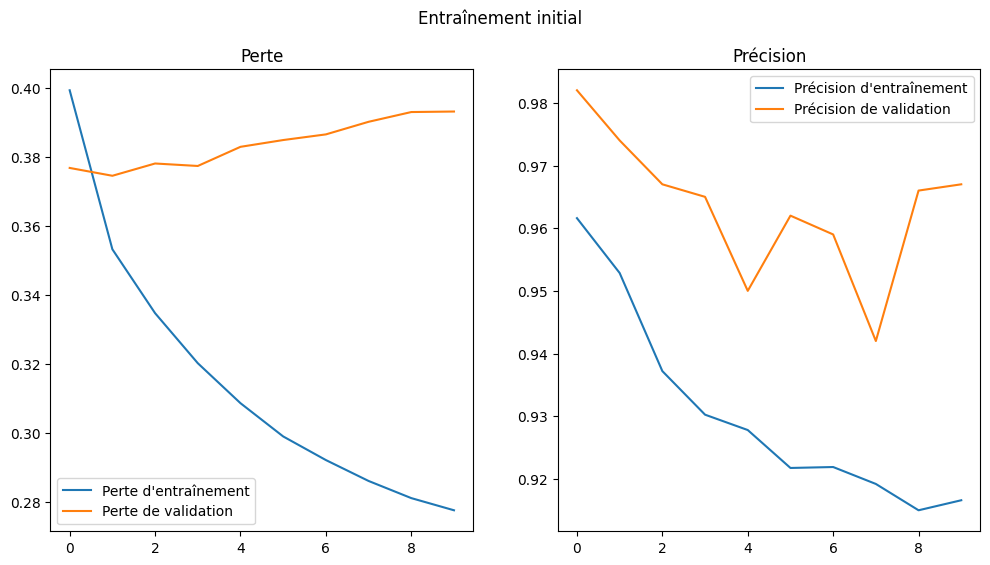

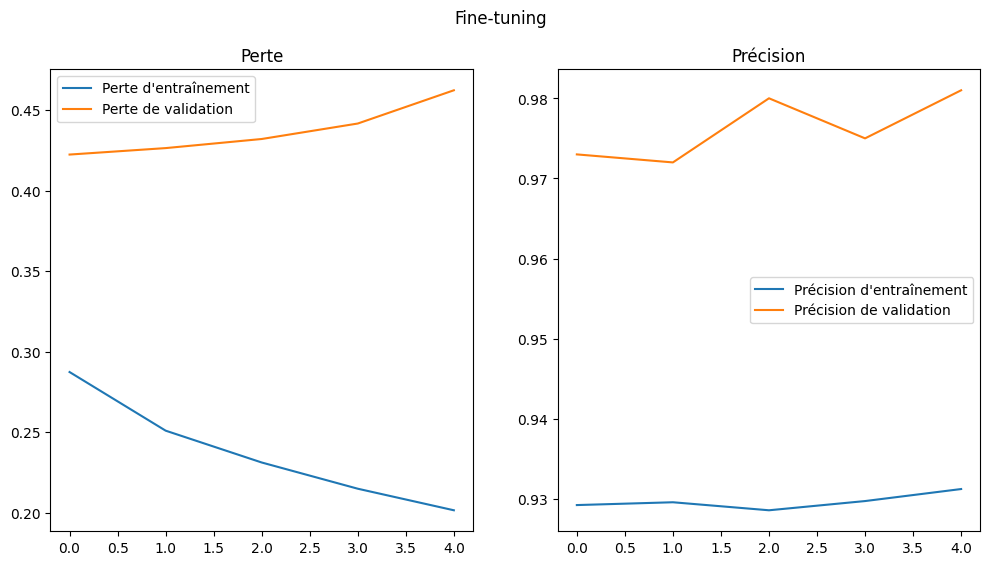

In [ ]:

# Plotter les résultats
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Perte d'entraînement")
    plt.plot(history["val_loss"], label="Perte de validation")
    plt.legend()
    plt.title("Perte")

    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"], label="Précision d'entraînement")
    plt.plot(history["val_accuracy"], label="Précision de validation")
    plt.legend()
    plt.title("Précision")

    plt.suptitle(title)
    plt.show()

plot_training_history(history.history, "Entraînement initial")
plot_training_history(fine_tuning_history.history, "Fine-tuning")